# Colony forming units (cfu) of mold versus air particulate measurements.

Two things I want to explore: 
* Is there a **particle count** difference between locations with **CFU** measurements above below 10?
* Are particulate counts an indicator of CFU counts?

In [1]:
#importing the tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

Explore the data relationships of all your features and understand how the
features compare to the response variable.

● Build data profiles and tables

○ Inferential statistics

● Explore data relationships

○ Data visualization

● Feature Selection and Engineering


### Loading data and building profiles

In [2]:
file = 'data\combined_VAS.csv'
df = pd.read_csv(file,index_col=0,parse_dates=True)
df['Date'] = pd.to_datetime(df['Date'])
df['Traffic'] = df['Traffic'].astype('category')
df['Weather'] = df['Weather'].astype('category')
df['cfu'] = pd.to_numeric(df['cfu'])
df.reset_index()
df.dtypes

Date                      datetime64[ns]
location                          object
Temp                             float64
RH                               float64
Total_Particles>0.3              float64
Total_Particles>0.5/m3           float64
Traffic                         category
Weather                         category
cfu                              float64
Source                            object
dtype: object

#### CFU 0 values are genuine 0s. CFU 34 values are spiked values as the true value could be > 34

# the values at 34 actually represent 34 and above
# for this reason I will take out the 34 values as they may not be accurate.
# Additionally, 44 samples are outdoors.
# particulates data
# dfvc = df['location'][df['cfu']==34].value_counts()
# df = df[df['cfu']<34] 

# print(dfvc)

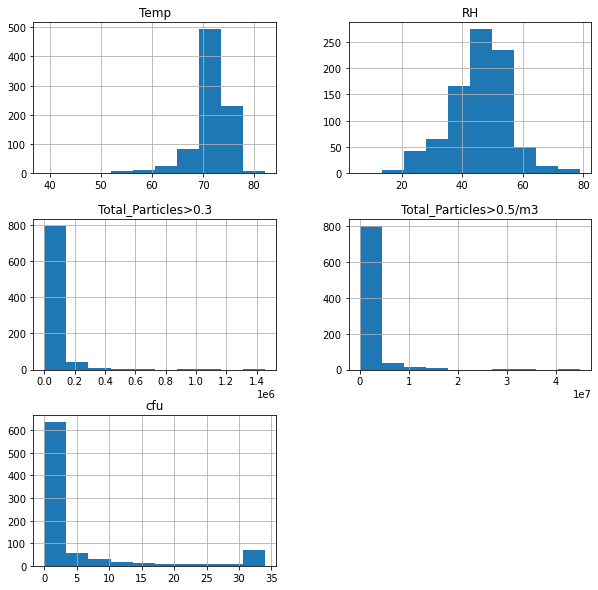

In [4]:
#several non-normal plots
hist = df.hist(bins=10, figsize=(10,10))

#### Adding a threshold value of 10.

In [5]:
#if i'm doing this, should I still consider the particulate data from CFU values of 34?
df['threshold'] = np.where(df['cfu'] < 10, 'under','over')

#### Seperating the data to only look at indoor values.

In [6]:
outside = 'MBH Shuttle Stop','ED Lot'
df['sample_type'] = np.where(df['location'] == outside, 'outdoor','indoor')
df_indoor = df[df['sample_type']=='indoor']

df_indoor.sample(6)

,Date,location,Temp,RH,Total_Particles>0.3,Total_Particles>0.5/m3,Traffic,Weather,cfu,Source,threshold,sample_type
1080,2016-11-21,OGT4-C4,70.3,51.4,192115.0,5412448.0,None,Scattered Clouds,34.0,MB,over,indoor
699,2017-06-29,B1-A4,72.4,48.0,47083.0,1944700.0,None,Partly Cloudy,1.0,MB,under,indoor
1471,2016-04-22,L26,71.0,52.2,4245.0,163669.0,Low,Mostly Cloudy,0.0,ML,under,indoor
1857,2015-08-31,HO-C6807,72.4,53.1,75216.0,3612219.0,Low,Partly Cloudy,2.0,MB,under,indoor
1916,2015-07-30,HO-C6835,73.5,50.0,6050.0,248136.0,Medium,NaN,1.0,MB,under,indoor
1998,2015-05-29,11L SEC,74.6,45.1,13520.0,303648.0,Medium,NaN,2.0,ML,under,indoor


### transforming the particulate data to normal

In [7]:
# particle count numbers are so large that I will scale them down
df_indoor['log03'] = np.log(df_indoor['Total_Particles>0.3'])
df_indoor['log05m3'] = np.log(df_indoor['Total_Particles>0.5/m3'])

logdf = df_indoor[['log03','log05m3','cfu','Source','threshold','location']]
logdf.shape

(859, 6)

#### now the CFU

In [8]:
#lets see if cfu can be normalized
z = np.asarray(logdf['cfu'])
z1 = np.asarray(df_indoor['Total_Particles>0.3'])
z2 = np.asarray(df_indoor['Total_Particles>0.5/m3'])

logdf['zcfu'] = (z - z.mean())/ z.std()
logdf['sqrtcfu'] = np.sqrt(z)
logdf['cbrtcfu'] = np.cbrt(z)
logdf['logcfu'] = np.log((1 + z)/2)
logdf['minmaxcfu'] = (z - z.min()) / (z.max() - z.min())
                
logdf['minmax03'] = (z1 - z1.min()) / (z1.max() - z1.min())
logdf['minmax05m3'] = (z2 - z2.min()) / (z2.max() - z2.min())

<ipython-input-8-b22bf509651d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logdf['zcfu'] = (z - z.mean())/ z.std()
<ipython-input-8-b22bf509651d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logdf['sqrtcfu'] = np.sqrt(z)
<ipython-input-8-b22bf509651d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

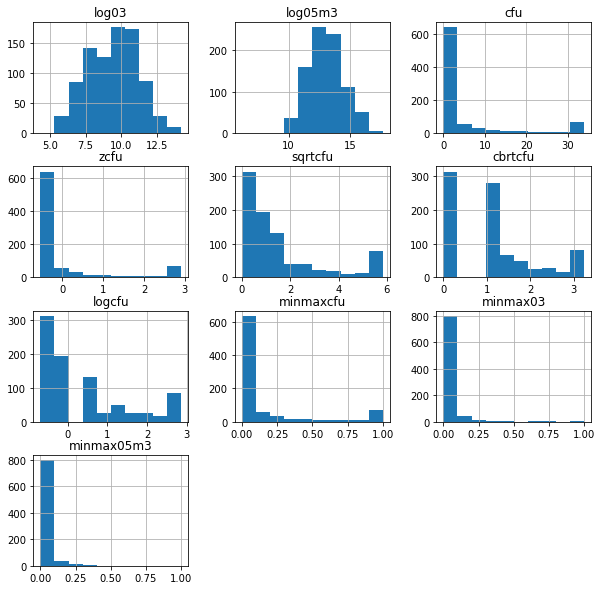

In [9]:
hist = logdf.hist(bins=10, figsize=(10,10))

okay CFU normalization not required.

## Now looking at over and under the 10 CFU threshold

In [10]:
dfT = logdf[['log03','log05m3','threshold']]
binsize = [10,11,12,13,14,15,16,17,18,19,20]

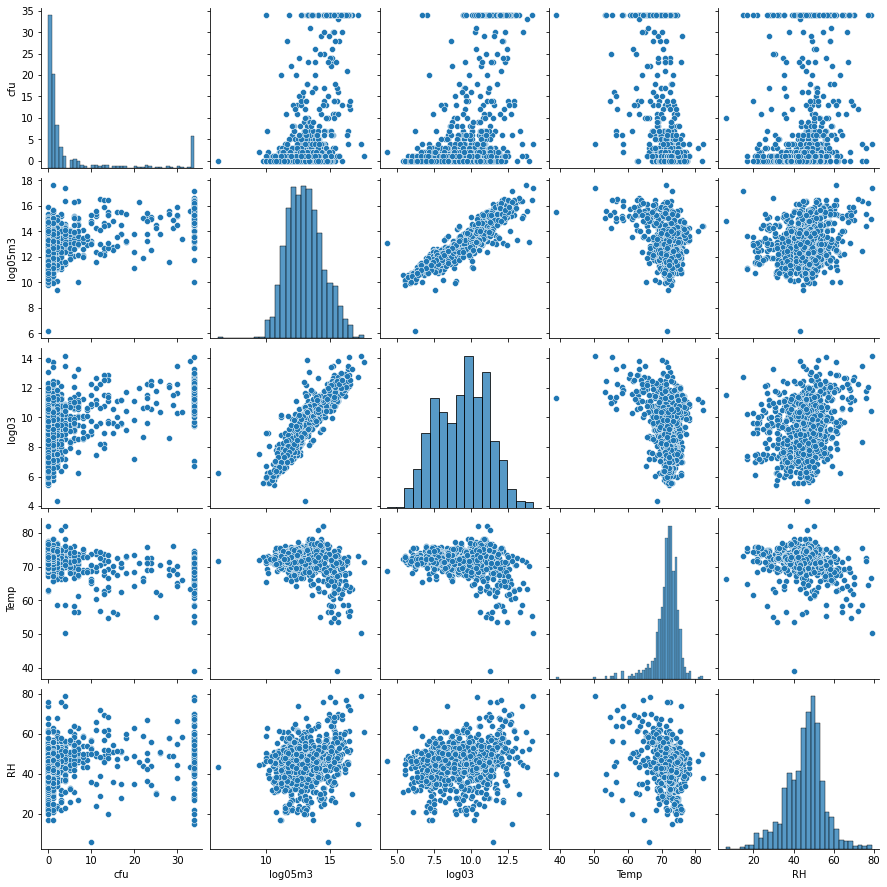

In [11]:
sns.pairplot(df_indoor[['cfu','log05m3','log03','Temp','RH']])

Temp and RH don't seem relevant

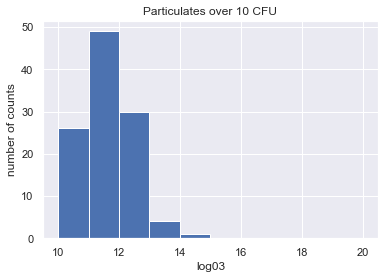

In [12]:
sns.set()
_ = plt.hist(logdf['log03'][dfT['threshold']=='over'],bins=binsize)
_ = plt.xlabel('log03')
_ = plt.ylabel('number of counts')
_ = plt.title('Particulates over 10 CFU')
plt.show()

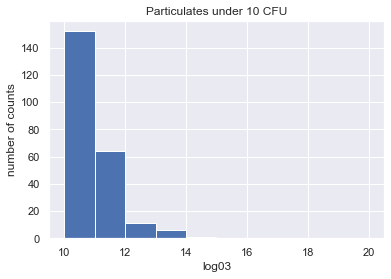

In [13]:
sns.set()
_ = plt.hist(logdf['log03'][dfT['threshold']=='under'],bins=binsize)
_ = plt.xlabel('log03')
_ = plt.ylabel('number of counts')
_ = plt.title('Particulates under 10 CFU')
plt.show()

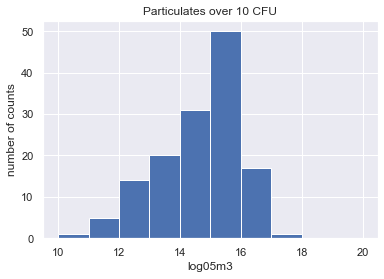

In [14]:
sns.set()
_ = plt.hist(logdf['log05m3'][dfT['threshold']=='over'],bins=binsize)
_ = plt.xlabel('log05m3')
_ = plt.ylabel('number of counts')
_ = plt.title('Particulates over 10 CFU')
plt.show()

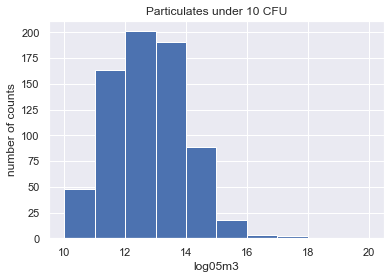

In [15]:
sns.set()
_ = plt.hist(logdf['log05m3'][dfT['threshold']=='under'],bins=binsize)
_ = plt.xlabel('log05m3')
_ = plt.ylabel('number of counts')
_ = plt.title('Particulates under 10 CFU')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 21.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


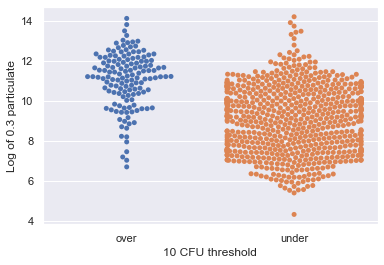

In [16]:
sns.set()
_ = sns.swarmplot(x='threshold', y='log03', data=logdf)
_ = plt.xlabel('10 CFU threshold')
_ = plt.ylabel('Log of 0.3 particulate')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 41.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


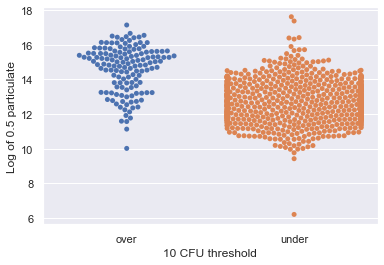

In [17]:
sns.set()
_ = sns.swarmplot(x='threshold', y='log05m3', data=logdf)
_ = plt.xlabel('10 CFU threshold')
_ = plt.ylabel('Log of 0.5 particulate')
plt.show()

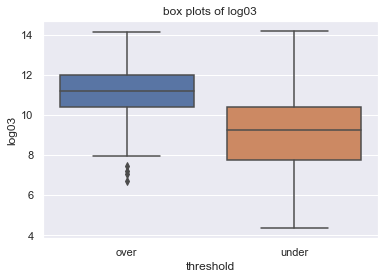

In [31]:
#not many outliers
sns.boxplot(x='threshold',y='log03',data=logdf)
_ = plt.title('box plots of log03')

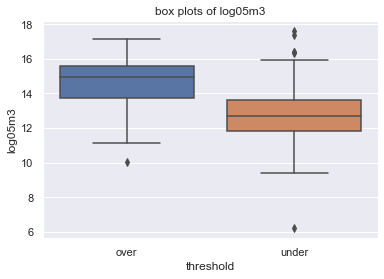

In [32]:
#see a few outliers. should I remove?
sns.boxplot(x='threshold',y='log05m3',data=logdf)
_ = plt.title('box plots of log05m3')

In [33]:
z = np.abs(stats.zscore(logdf['log05m3']))
print(np.where(z > 3))

(array([  5,  54, 646], dtype=int64),)


In [34]:
logdf.groupby('threshold').describe()

log03                                                       \
           count       mean       std       min        25%        50%   
threshold                                                               
over       139.0  11.055837  1.385808  6.705639  10.365096  11.205843   
under      720.0   9.093039  1.640065  4.336100   7.730722   9.223701   

                                log05m3             ... minmax05m3           \
                 75%        max   count       mean  ...        75%      max   
threshold                                           ...                       
over       11.999808  14.106888   139.0  14.609551  ...   0.128673  0.62033   
under      10.376351  14.190010   720.0  12.728745  ...   0.017960  1.00000   

          Permutation1                                                       \
                 count       mean       std       min        25%        50%   
threshold                                                                     
over             139.0  13.107666  1.475111  9.968292  11.972990  12.841657   
under            720.0  13.018692  1.425531  6.204558  11.974309  12.986694   

                                
                 75%       max  
threshold                       
over       14.098101  17.62326  
under      13.923135  17.37741  

[2 rows x 88 columns]

In [22]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

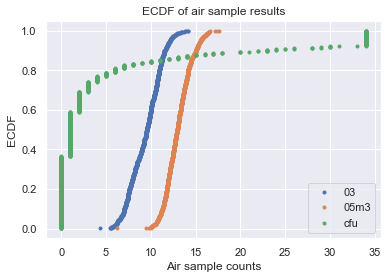

In [23]:
x_03, y_03 = ecdf(logdf['log03'])
x_05, y_05 = ecdf(logdf['log05m3'])
x_cfu, y_cfu = ecdf(logdf['cfu'])

plt.plot(x_03, y_03,marker='.',linestyle='none')
plt.plot(x_05, y_05,marker='.',linestyle='none')
plt.plot(x_cfu, y_cfu,marker='.',linestyle='none')

_ = plt.xlabel('Air sample counts')
_ = plt.ylabel('ECDF')
_ = plt.title('ECDF of air sample results')
_ = plt.legend(['03', '05m3', 'cfu'])
plt.show()

#### As expected, the particulate measurements are similar. The CFU value is clearly a different shape

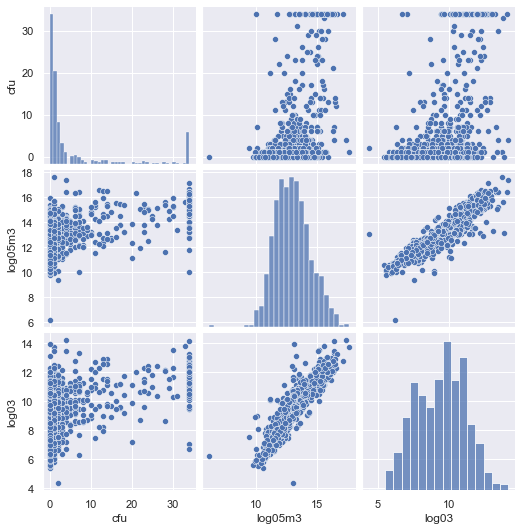

In [36]:
sns.pairplot(df_indoor[['cfu','log05m3','log03']])

In [25]:
def pearson_r(x, y):
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x, y)

    # Return entry [0,1]
    return corr_mat[0,1]

# Compute Pearson correlation coefficient
r = pearson_r(logdf['cfu'],logdf['log03'])

# Print the result
print(r)

0.44419518688880255


In [26]:
r = pearson_r(logdf['cfu'],logdf['log05m3'])

print(r)

0.5183945991996636


In [37]:
r = pearson_r(logdf['cfu'],logdf['log03'])

print(r)

0.44419518688880255


In [38]:
pearson_r(logdf['log03'],logdf['log05m3'])

0.8941727122551806

### Is there a difference in particulate counts above and below 10cfu? Not likely as the means are so close.

In [28]:
logdf['Permutation1'] = np.random.permutation(logdf['log05m3'])
 
logdf.groupby('threshold')['Permutation1'].describe()

,count,mean,std,min,25%,50%,75%,max
threshold,,,,,,,,
over,139.0,13.107666,1.475111,9.968292,11.972990,12.841657,14.098101,17.62326
under,720.0,13.018692,1.425531,6.204558,11.974309,12.986694,13.923135,17.37741


In [29]:
logdf.groupby('threshold')['log05m3'].describe()

,count,mean,std,min,25%,50%,75%,max
threshold,,,,,,,,
over,139.0,14.609551,1.343846,10.018511,13.714785,14.966918,15.572834,17.145764
under,720.0,12.728745,1.237430,6.204558,11.856219,12.722704,13.604224,17.623260


here I remove the 34 CFU values as they actually represent greater than 34.

In [30]:
logdf33 = logdf[logdf['cfu']<34]
logdf33.groupby('threshold')['log05m3'].describe()

,count,mean,std,min,25%,50%,75%,max
threshold,,,,,,,,
over,73.0,14.216956,1.333273,11.132763,13.133258,14.517890,15.274618,16.550635
under,720.0,12.728745,1.237430,6.204558,11.856219,12.722704,13.604224,17.623260


just looking at log03 mean differences when permutated

In [40]:
logdf['Permutation1'] = np.random.permutation(logdf['log03'])
 
logdf.groupby('threshold')['Permutation1'].describe()

,count,mean,std,min,25%,50%,75%,max
threshold,,,,,,,,
over,139.0,9.317051,1.679221,5.7301,8.135384,9.363662,10.408785,14.106888
under,720.0,9.428721,1.771852,4.3361,7.946070,9.641180,10.774226,14.190010
